In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

In [2]:
#import the data from a csv file.
data = pd.read_csv("Sampledata.csv", index_col = 0)

In [3]:
data.head(5)

,pickup_datetime,duration,pickup_x,pickup_y,dropoff_x,dropoff_y
306292,2034-03-17 13:20:06,820,114.183260,447.522979,57.259465,550.390795
946559,2034-04-03 19:17:16,158,156.133477,369.467962,155.501321,362.302553
619330,2034-01-16 21:07:01,238,152.287433,308.425885,163.324297,325.564501
1262444,2034-03-17 10:27:55,681,138.671000,328.503188,161.294155,311.626149
964120,2034-03-13 09:49:05,221,136.117200,312.080288,138.287227,319.631925


In [4]:
data.columns

Index(['pickup_datetime', 'duration', 'pickup_x', 'pickup_y', 'dropoff_x',
       'dropoff_y'],
      dtype='object')

In [5]:
data.shape

(130000, 6)

In [6]:
data = data[data.duration != 0]

In [7]:
data.shape

(129999, 6)

In [8]:
columns = ["pickup_datetime", "duration" ,"pickup_x" ,"pickup_y" ,"dropoff_x" ,"dropoff_y"]
data = data[columns]

In [9]:
data.isna().sum()

pickup_datetime    0
duration           0
pickup_x           0
pickup_y           0
dropoff_x          0
dropoff_y          0
dtype: int64

In [10]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['pickup_datetime'].head()

306292    2034-03-17 13:20:06
946559    2034-04-03 19:17:16
619330    2034-01-16 21:07:01
1262444   2034-03-17 10:27:55
964120    2034-03-13 09:49:05
Name: pickup_datetime, dtype: datetime64[ns]

In [11]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.weekday_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [12]:
data.head()

,pickup_datetime,duration,pickup_x,pickup_y,dropoff_x,dropoff_y,weekday,month,weekday_num,pickup_hour
306292,2034-03-17 13:20:06,820,114.183260,447.522979,57.259465,550.390795,Friday,3,4,13
946559,2034-04-03 19:17:16,158,156.133477,369.467962,155.501321,362.302553,Monday,4,0,19
619330,2034-01-16 21:07:01,238,152.287433,308.425885,163.324297,325.564501,Monday,1,0,21
1262444,2034-03-17 10:27:55,681,138.671000,328.503188,161.294155,311.626149,Friday,3,4,10
964120,2034-03-13 09:49:05,221,136.117200,312.080288,138.287227,319.631925,Monday,3,0,9


In [13]:
data['weekday'].unique()

array(['Friday', 'Monday', 'Thursday', 'Wednesday', 'Saturday', 'Sunday',
       'Tuesday'], dtype=object)

# Calculating Distance

In [14]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_x'], df['pickup_y'])
    drop = (df['dropoff_x'], df['dropoff_y'])
    return haversine(pickup, drop)

# Clustering

In [15]:
df_pickup = data.filter(['duration','pickup_x', 'pickup_y'], axis=1)
df_drop = data.filter(['duration','dropoff_x', 'dropoff_y'], axis=1)

#df_clustering = data['pickup_x', 'pickup_y','dropoff_x', 'dropoff_y']

In [16]:
df_pickup.shape

(129999, 3)

In [17]:
df_pickup.columns = ['duration','x','y']
df_drop.columns = ['duration','x','y']

In [18]:
df_drop.head()

,duration,x,y
306292,820,57.259465,550.390795
946559,158,155.501321,362.302553
619330,238,163.324297,325.564501
1262444,681,161.294155,311.626149
964120,221,138.287227,319.631925


In [59]:
df_drop.shape

(129999, 3)

In [19]:
frames = [df_pickup,df_drop]

In [20]:
df_final = pd.concat(frames, axis=0)

In [21]:
df_final.head()

,duration,x,y
306292,820,114.183260,447.522979
946559,158,156.133477,369.467962
619330,238,152.287433,308.425885
1262444,681,138.671000,328.503188
964120,221,136.117200,312.080288


In [22]:
df_final.shape

(259998, 3)

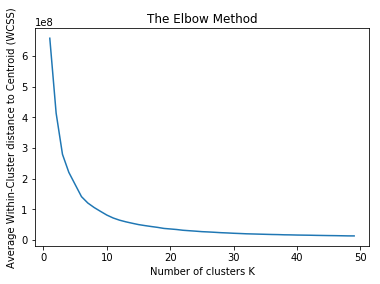

In [72]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 50):
  kmeans=KMeans(n_clusters=i, init='k-means++', max_iter= 300, n_init= 10, random_state= 0)
  kmeans.fit(df_final[['x','y']])
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 50),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters K')
plt.ylabel('Average Within-Cluster distance to Centroid (WCSS)')  
plt.show()

In [24]:
# Applying k-means
from sklearn.cluster import KMeans
kmeans=KMeans(n_clusters=15, init='k-means++', max_iter= 350, n_init= 10, random_state= 0)
df_final.loc[:, 'cluster'] = kmeans.fit_predict(df_final[['x','y']])

In [25]:
df_final.head()

,duration,x,y,cluster
306292,820,114.183260,447.522979,1
946559,158,156.133477,369.467962,6
619330,238,152.287433,308.425885,0
1262444,681,138.671000,328.503188,18
964120,221,136.117200,312.080288,29


In [26]:
kmeans.cluster_centers_

array([[  152.35291955,   310.78847651],
       [  116.35107968,   442.04974026],
       [  175.59138461,   348.73212371],
       [  -32.15349184,   461.82207297],
       [ 5284.01817359, -3304.26970507],
       [   92.32459321,   301.25689173],
       [  156.62198775,   361.8486004 ],
       [  129.56960678,   316.87224338],
       [  184.25506629,   365.28945755],
       [ 2685.01316498,  1385.37309581],
       [  147.69742092,   336.37567375],
       [   44.34885145,   271.53653629],
       [   -9.38821344,   628.66836833],
       [  181.73802741,   129.93265529],
       [  215.12514326,   423.21927732],
       [  152.89779182,   347.82023213],
       [   67.20872039,   346.0063806 ],
       [  106.53201808,   342.19006852],
       [  142.58084631,   323.38597973],
       [  128.0485669 ,   290.06698825],
       [  223.19380718,  -149.70337484],
       [   54.22526175,   454.9142276 ],
       [  163.62687345,   372.8712884 ],
       [  157.56986616,   325.1741977 ],
       [  127.78

In [27]:
df_final.head()

,duration,x,y,cluster
306292,820,114.183260,447.522979,1
946559,158,156.133477,369.467962,6
619330,238,152.287433,308.425885,0
1262444,681,138.671000,328.503188,18
964120,221,136.117200,312.080288,29


In [28]:
df_save = df_final

In [35]:
dp = pd.merge(df_pickup, df_final, on=['duration','x', 'y'], how = 'inner')

In [36]:
dp.shape

(129999, 4)

In [37]:
dp.head(5)

,duration,x,y,cluster
0,820,114.183260,447.522979,1
1,158,156.133477,369.467962,6
2,238,152.287433,308.425885,0
3,681,138.671000,328.503188,18
4,221,136.117200,312.080288,29


In [63]:
dp.columns = ['duration','pickup_x','pickup_y','pickup_cluster']

In [38]:
df_save.shape

(259998, 4)

In [60]:
dd = pd.merge(df_drop, df_final, on=['duration','x', 'y'], how = 'left')

In [61]:
dd.shape

(130001, 4)

In [66]:
dd.columns = ['duration','dropoff_x','dropoff_y','dropoff_cluster']

In [41]:
dd.head(5)

,duration,x,y,cluster
0,820,57.259465,550.390795,21
1,158,155.501321,362.302553,6
2,238,163.324297,325.564501,23
3,681,161.294155,311.626149,0
4,221,138.287227,319.631925,18


In [57]:
type(x)

pandas.core.series.Series

In [64]:
data = pd.merge(dp, data, on=['duration','pickup_x', 'pickup_y'], how = 'inner')

In [65]:
data.head(5)

,duration,pickup_x,pickup_y,pickup_cluster,pickup_datetime,dropoff_x,dropoff_y,weekday,month,weekday_num,pickup_hour
0,820,114.183260,447.522979,1,2034-03-17 13:20:06,57.259465,550.390795,Friday,3,4,13
1,158,156.133477,369.467962,6,2034-04-03 19:17:16,155.501321,362.302553,Monday,4,0,19
2,238,152.287433,308.425885,0,2034-01-16 21:07:01,163.324297,325.564501,Monday,1,0,21
3,681,138.671000,328.503188,18,2034-03-17 10:27:55,161.294155,311.626149,Friday,3,4,10
4,221,136.117200,312.080288,29,2034-03-13 09:49:05,138.287227,319.631925,Monday,3,0,9


In [67]:
data = pd.merge(dd, data, on=['duration','dropoff_x', 'dropoff_y'], how = 'inner')

In [68]:
data.head(5)

,duration,dropoff_x,dropoff_y,dropoff_cluster,pickup_x,pickup_y,pickup_cluster,pickup_datetime,weekday,month,weekday_num,pickup_hour
0,820,57.259465,550.390795,21,114.183260,447.522979,1,2034-03-17 13:20:06,Friday,3,4,13
1,158,155.501321,362.302553,6,156.133477,369.467962,6,2034-04-03 19:17:16,Monday,4,0,19
2,238,163.324297,325.564501,23,152.287433,308.425885,0,2034-01-16 21:07:01,Monday,1,0,21
3,681,161.294155,311.626149,0,138.671000,328.503188,18,2034-03-17 10:27:55,Friday,3,4,10
4,221,138.287227,319.631925,18,136.117200,312.080288,29,2034-03-13 09:49:05,Monday,3,0,9


In [69]:
data.shape

(130005, 12)

In [70]:
data = data[data.duration != 0]

In [71]:
data.shape

(130005, 12)

In [72]:
data.isna().sum()

duration           0
dropoff_x          0
dropoff_y          0
dropoff_cluster    0
pickup_x           0
pickup_y           0
pickup_cluster     0
pickup_datetime    0
weekday            0
month              0
weekday_num        0
pickup_hour        0
dtype: int64

In [73]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,duration,int64
1,dropoff_x,float64
2,dropoff_y,float64
3,dropoff_cluster,int32
4,pickup_x,float64
5,pickup_y,float64
6,pickup_cluster,int32
7,pickup_datetime,datetime64[ns]
8,weekday,object
9,month,int64


In [74]:
data[['month', 'weekday_num', 'pickup_hour','pickup_cluster','dropoff_cluster']] = data[['month', 'weekday_num', 'pickup_hour','pickup_cluster','dropoff_cluster']].astype(str)

In [75]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,duration,int64
1,dropoff_x,float64
2,dropoff_y,float64
3,dropoff_cluster,object
4,pickup_x,float64
5,pickup_y,float64
6,pickup_cluster,object
7,pickup_datetime,datetime64[ns]
8,weekday,object
9,month,object
